<a href="https://colab.research.google.com/github/MariaEspFon/Scripts-propios/blob/main/TensorFlow/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MODELO 1: red neuronal convolucional (CNN)

## 1. Inicialización de Keras y TensorFlow

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version: ", tf.__version__)

from tensorflow import keras
#print("Keras version: ", tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from math import ceil

%reload_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU Available:  []
TensorFlow version:  2.18.0


## 2. Carga de datos EDA desde Github

In [3]:
url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_D7_1.csv'
column_names = ['Mean', 'Median', 'Standard Dev', 'Max Value', 'Min Value', 'Standard Dev 1st diff',
                'Median 1st diff', 'Standard Dev 2nd diff', 'Total Area', 'Kurtosis',
                'Power', '99% Bandwidth', 'Top Bandwidth Frequency',
                'Phasic mean', 'Phasic Stdev', 'Phasic AuC', 'Tonic mean', 'Tonic Stdev', 'Tonic AuC',  'State' ]
raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=True)

size = raw_dataset.shape
print(f'Formato del dataset: {size}')

class_counts = raw_dataset['State'].value_counts()
print("Recuento de instancias por clase:")
print(class_counts)

Formato del dataset: (4471, 20)
Recuento de instancias por clase:
State
1    2739
0    1732
Name: count, dtype: int64


In [4]:
raw_dataset.head() # muestra las primeras 5 filas por defecto
raw_dataset.tail() # muestra las últimas 5 filas por defecto

,Mean,Median,Standard Dev,Max Value,Min Value,Standard Dev 1st diff,Median 1st diff,Standard Dev 2nd diff,Total Area,Kurtosis,Power,99% Bandwidth,Top Bandwidth Frequency,Phasic mean,Phasic Stdev,Phasic AuC,Tonic mean,Tonic Stdev,Tonic AuC,State
4466,1.466113,1.566922,1.261131,3.142194,-0.076818,0.183625,0.002763,0.093909,174.826977,1.231085,447.202123,0.517393,0.517538,2.650141,3.726599,78.992107,-3.209107,1.263214,-95.019918,1
4467,0.540481,0.034924,0.963236,3.007747,-0.231767,0.171018,0.000410,0.068237,63.761552,3.701841,145.465354,0.969150,0.969496,1.919576,2.938044,54.869583,-3.763126,1.339107,-111.580315,1
4468,2.449819,2.981136,1.047429,3.098601,0.061658,0.102151,0.000678,0.043690,292.429905,3.509624,850.749576,0.402680,0.402778,1.049711,1.670153,31.491325,-0.741003,1.967254,-21.775323,1
4469,2.944428,2.946765,0.031031,3.030734,2.796635,0.014701,-0.000828,0.009593,350.382482,10.605559,1040.473268,0.016502,0.016585,0.072713,0.296073,2.045646,1.257076,0.145131,37.424606,1
4470,2.840264,2.868869,0.263836,2.909742,0.000000,0.257542,-0.000595,0.258572,339.376835,113.812119,976.335639,0.806445,0.806529,0.539952,1.058184,16.198553,0.802859,0.775748,23.916348,1


## 3. Preprocesamiento de datos

### 3.1. Extracción de los conjuntos de entrenamiento, prueba y validación

*   Datos de **entrenamiento**: para el aprendizaje de parámetros.
*   Datos de **prueba**: para hacer test de predicciones.
*   Datos de **validación**: para afinar hiperparámetros.



In [5]:
# Extracción de subconjuntos: bloque de código para mantener la proporción de clases
from sklearn.model_selection import train_test_split

features = raw_dataset.drop('State', axis=1)
labels = raw_dataset['State']
train_dataset, test_dataset, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=0)

In [ ]:
# Extracción de subconjuntos: bloque de código original original
train_dataset = raw_dataset.sample(frac=0.8,random_state=0)
# random_state=0 marca la semilla aleatoria para escoger muestras
test_dataset = raw_dataset.drop(train_dataset.index)
# drop coge el resto de datos desde la posición final de train_dataset
train_labels = train_dataset.pop('State')
test_labels = test_dataset.pop('State')
#del train_dataset['Number of SCR']
#del test_dataset['Number of SCR']

In [6]:
#del train_dataset['Power']
#del test_dataset['Power']
#del train_dataset['Total Area']
#del test_dataset['Total Area']
#a= train_dataset.pop('Power')
#b=train_dataset.pop('Total Area')
#c=test_dataset.pop('Power')
#d=test_dataset.pop('Total Area')
train_size = train_dataset.shape
test_size = test_dataset.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

Formato del dataset de training: (3576, 19)
Formato del dataset de test: (895, 19)


In [7]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Mean,3576.0,1.344283,2.486809,2.837595e-04,0.235626,0.420386,1.018402,16.584792
Median,3576.0,1.347576,2.502958,1.507318e-16,0.234684,0.420156,1.015974,17.078574
Standard Dev,3576.0,0.139490,0.362938,3.715939e-04,0.005894,0.028616,0.112155,6.557046
Max Value,3576.0,1.589539,2.759773,3.862719e-03,0.289417,0.487698,1.344151,19.922996
Min Value,3576.0,1.073124,2.277522,-3.023070e-01,0.094649,0.294296,0.662812,16.049411
Standard Dev 1st diff,3576.0,0.022213,0.042807,2.152890e-04,0.001014,0.005374,0.022249,0.798314
Median 1st diff,3576.0,-0.000686,0.003735,-1.354304e-01,-0.000516,-0.000053,0.000056,0.036675
Standard Dev 2nd diff,3576.0,0.010437,0.019055,1.297775e-04,0.000576,0.002739,0.011228,0.380591
Total Area,3576.0,159.971009,295.963119,3.286816e-02,28.023783,50.010245,121.143400,1981.662176
Kurtosis,3576.0,4.971038,5.430407,1.026555e+00,2.112806,2.948435,5.463178,113.812119


### 3.2. Normalización y estandarización de todos los datos

In [8]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
train_size = normed_train_data.shape
test_size = normed_test_data.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

Formato del dataset de training: (3576, 19)
Formato del dataset de test: (895, 19)


In [9]:
normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

,count,mean,std,min,25%,50%,75%,max
Mean,3576.0,7.947905e-18,1.0,-0.540451,-0.445815,-0.371519,-0.131044,6.128540
Median,3576.0,-1.172316e-16,1.0,-0.538394,-0.444631,-0.370530,-0.132484,6.284963
Standard Dev,3576.0,4.967441e-18,1.0,-0.383311,-0.368094,-0.305490,-0.075315,17.682257
Max Value,3576.0,-3.973953e-17,1.0,-0.574568,-0.471097,-0.399251,-0.088916,6.643102
Min Value,3576.0,2.086325e-17,1.0,-0.603916,-0.429623,-0.341963,-0.180157,6.575694
Standard Dev 1st diff,3576.0,-8.345301e-17,1.0,-0.513886,-0.495218,-0.393376,0.000846,18.130420
Median 1st diff,3576.0,0.000000e+00,1.0,-36.078873,0.045384,0.169392,0.198762,10.003738
Standard Dev 2nd diff,3576.0,2.185674e-17,1.0,-0.540907,-0.517504,-0.403980,0.041537,19.425773
Total Area,3576.0,3.775255e-17,1.0,-0.540399,-0.445823,-0.371535,-0.131191,6.155129
Kurtosis,3576.0,1.390883e-17,1.0,-0.726370,-0.526339,-0.372459,0.090627,20.042895


## 4. Creación del modelo CNN

El primer modelo cuenta con 2 tipos de capas:
*     Capas convolucionales con un número variable de filtros de (2x1) o (3x1).
*     Capas densas en la salida para integrar toda la información convolucional y hacer la clasificación binaria (para la cual sólo es necesaria una neurona y una función sigmoid de activación).

Además, se incluye una capa accesoria para preparar los datos antes de la capa de salida (capa Flatten)

In [10]:
from keras import Sequential, layers, activations

def build_model_best(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

def build_model_ELU(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Conv1D(22, 3, padding='valid'))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Conv1D(18, 4, padding='valid'))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Conv1D(9, 4, padding='valid'))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  # compilación del modeo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_best(train_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 19, 27)         │            81 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19, 27)         │           108 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 19, 22)         │         1,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 22)         │            88 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 19, 22)         │         1,474 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 19, 22)         │            88 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 418)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 22)             │         9,218 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,884 (50.33 KB)

 Trainable params: 12,742 (49.77 KB)

 Non-trainable params: 142 (568.00 B)

## 5. Entrenamiento del modelo

Reservamos el 20% de los datos de entrenamiento para la validación del modelo

In [11]:
from keras import callbacks
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # o 'val_accuracy'
    patience=100,              # número de épocas que espera sin mejora
    restore_best_weights=True  # para recuperar los mejores pesos
)

In [12]:
EPOCHS = 1500
#BATCH_SIZE = train_size[0]
BATCH_SIZE = ceil(train_size[0]*0.1)
history = model.fit(normed_train_data, train_labels, batch_size=BATCH_SIZE,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0)

In [13]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,binary_accuracy,f1_score,loss,precision,recall,val_binary_accuracy,val_f1_score,val_loss,val_precision,val_recall,epoch
1495,0.959441,0.776892,0.100187,0.960135,0.974359,0.779330,0.765957,1.458565,0.806167,0.839450,1495
1496,0.954545,0.777236,0.102561,0.961386,0.964672,0.777933,0.766372,1.475208,0.799136,0.848624,1496
1497,0.958741,0.778789,0.101365,0.967982,0.964672,0.790503,0.766637,1.472607,0.812227,0.853211,1497
1498,0.959441,0.777581,0.100329,0.962733,0.971510,0.768156,0.767730,1.524831,0.806818,0.814220,1498
1499,0.953846,0.778961,0.104814,0.964511,0.960114,0.784916,0.765957,1.534373,0.803879,0.855505,1499


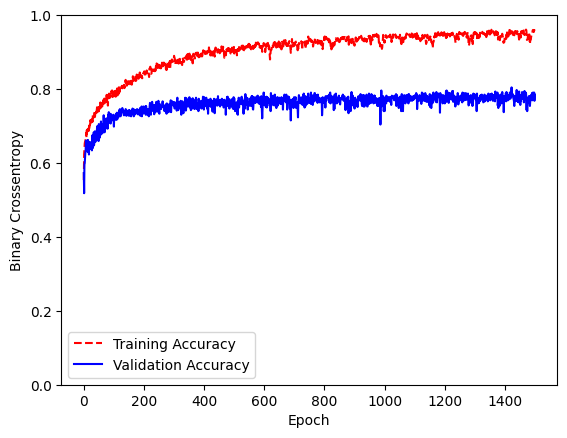

In [14]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Binary Crossentropy')
  plt.plot(hist['epoch'], hist['binary_accuracy'],'r--',
           label='Training Accuracy')
  plt.plot(hist['epoch'], hist['val_binary_accuracy'],'b',
           label = 'Validation Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

## 6. Validación del modelo con los datos de test


In [15]:
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(normed_test_data, test_labels, batch_size=(test_size[0]))
print(f'Test accuracy: {100*test_acc:.2f}%')
print(f'Test loss: {test_loss:.3f}')
# TensorFlow imprime las métricas en orden alfabético por defecto en la consola,
# pero el método evaluate() devuelve los valores en el mismo orden en que fueron definidos en model.compile().

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - binary_accuracy: 0.8134 - f1_score: 0.7680 - loss: 1.2453 - precision: 0.8159 - recall: 0.8978
Test accuracy: 81.34%
Test loss: 1.245


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predictions = model.predict(normed_test_data)
predicted_labels = (predictions > 0.5).astype(int)
cm = confusion_matrix(test_labels, predicted_labels)

# Muestra la matriz de confusión
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(cm)

# Muestra métricas adicionales
print("Reporte de clasificación:")
print(classification_report(test_labels, predicted_labels, target_names=['Clase 0', 'Clase 1']))


 1/28 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step